<center><h1>Olivetti Face Recognition</h1></center>

<br><br><br><br><br>

## Contents
<b>
    <ul>
        <li>1. Summary</li>
        <li>2. Face Recognition Using PCA</li>
        <li>
             3. Olivetti Face Dataset
            <ul>
                <li>3.1. Show 48 Disticnt People in the Olivetti Dataset</li>
                <li>3.2. Show 10 Face Images of Selected Target</li>
            </ul>
        </li>
    </ul>
</b>


## 1. Summary

In this study, face recognition was performed using the face images in the Olivetti data set. The steps for face recognition are as follows:
- Principal components of face images were obtained by PCA.
- Adequate number of principal components determined
- According to three different classification models, accuracy score obtained.
- According to three different classification models, cross-validation accuracy score were obtained.
- Parameter optimization of the best model has been made.
<br>

## 2. Face Recognition Using PCA

<p>
Global-based methods are applied to face recognition by researchers because they perform facial recognition without feature extraction which is troublesome in feature based methods. Globally based methods have been used in face recognition since the 1990s, since they significantly improve facial recognition efficiency. Kirby and Sirovich (1990) first developed a method known as Eigenface, which is used in facial representation and recognition based on Principal Component Analysis . With this method, Turk and Pentland transformed the entire face image into vectors and computed eigenfaces with a set of samples. PCA was able to obtain data representing the face at the optimum level with the data obtained from the image. The different facial and illumination levels of the same person were evaluated as the weakness point of PCA.
</p>

## 3. Olivetti Dataset

Brief information about Olivetti Dataset:
- Face images taken between April 1992 and April 1994.
- There are ten different image of each of 40 distinct people
- There are 400 face images in the dataset
- Face images were taken at different times, variying ligthing, facial express and facial detail
- All face images have black background
- The images are gray level
- Size of each image is 64x64
- Image pixel values were scaled to [0, 1] interval
- Names of 40 people were encoded to an integer from 0 to 39
<br>

<b>Importing necessary libraries<b>

The file ``requirements.txt`` contain the necessary libraries, so you need just to run this cell below.

In [1]:
%%capture
!pip install -r requirements.txt

Importing the necessary libraries such as numpy, pandas and scikit-learn and more.

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import mglearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from numpy.random import RandomState
from sklearn import decomposition
from sklearn.svm import SVC
from sklearn import metrics
from time import time

This amazing one is to make the plots in line its mean the plots will show in notebook whis ggplot style.

In [85]:
%matplotlib inline 
plt.style.use('ggplot')

Loading data.

In [86]:
data=np.load("data/olivetti_faces.npy")
target=np.load("data/olivetti_faces_target.npy")

Let's verify above information

In [87]:
print("There are {} images in the dataset".format(len(data)))
print("There are {} unique targets in the dataset".format(len(np.unique(target))))
print("Size of each image is {}x{}".format(data.shape[1],data.shape[2]))
print("Pixel values were scaled to [0,1] interval. e.g:{}".format(data[0][0,:4]))

There are 400 images in the dataset
There are 40 unique targets in the dataset
Size of each image is 64x64
Pixel values were scaled to [0,1] interval. e.g:[0.30991736 0.3677686  0.41735536 0.44214877]


In [88]:
print("unique target number : ",np.unique(target))

unique target number :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


<br>

### 3.1. Show 48 Disticnt People in the Olivetti Dataset

In [89]:
def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")

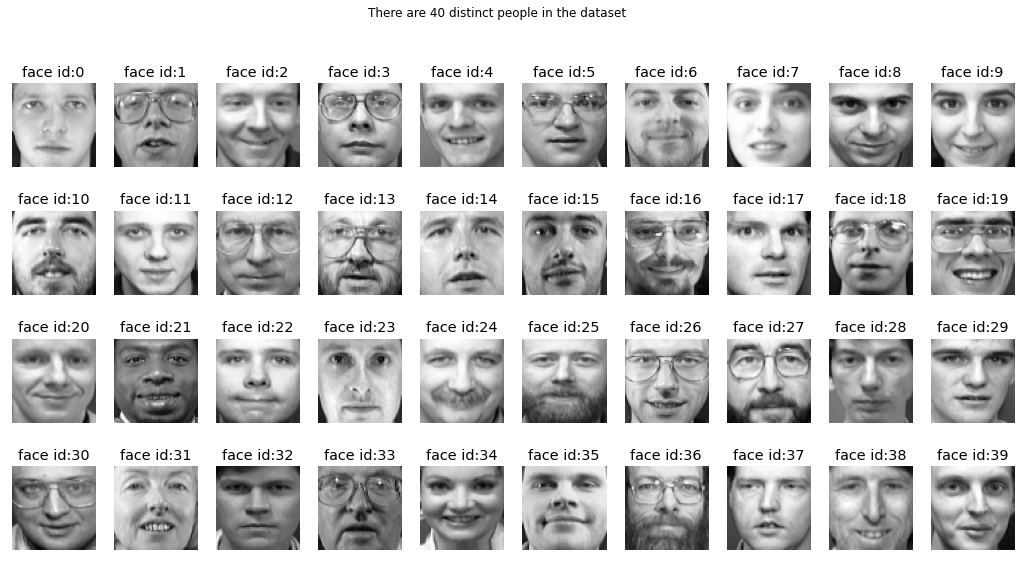

In [90]:
show_40_distinct_people(data, np.unique(target))

<p>As seen in the photo gallery above, the data set has 40 different person-owned, facial images.</p>

<br>

### 3.2. Show 10 Face Images of Selected Target

In [91]:
def show_10_faces_of_n_subject(images, subject_ids):
    # each subject has 10 distinct face images
    cols=10
    rows=(len(subject_ids)*10)/cols
    rows=int(rows)
    # rowsx10 dimensions
    # print('{} x {}'.format(rows, cols))
    
    fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(18,9))
    # axarr=axarr.flatten()
    
    for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index=subject_id*10 + j
            axarr[i,j].imshow(images[image_index], cmap="gray")
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            axarr[i,j].set_title("face id:{}".format(subject_id))

You can playaround ``subject_ids`` to see other people faces

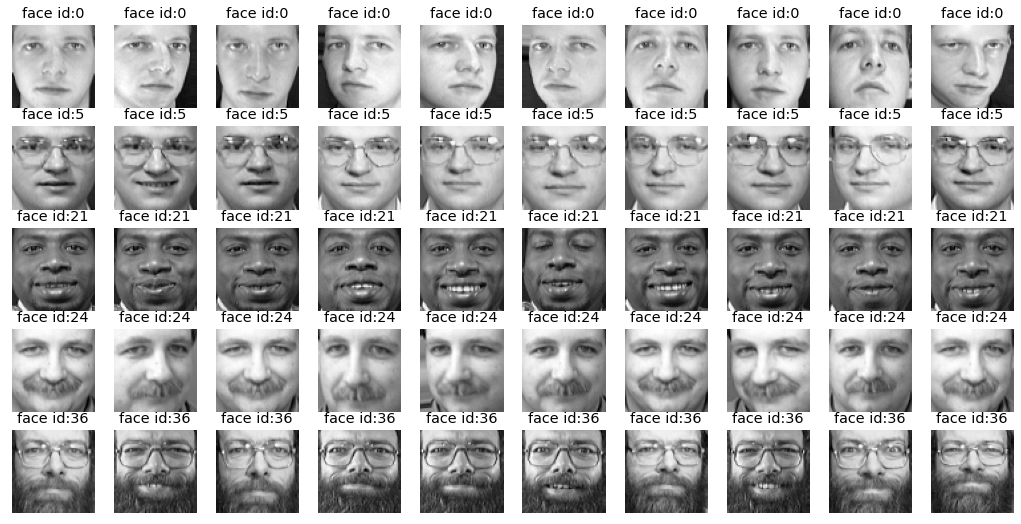

In [92]:
show_10_faces_of_n_subject(images=data, subject_ids=[0, 5, 21, 24, 36])

<p>
Each face of a subject has different characteristic in context of varying lighting, facial express and facial detail(glasses, beard)
</p>
<br>

## 4. Machine Learning Model fo Face Recognition

Machine learning models can work on vectors. Since the image data is in the matrix form, it must be converted to a vector.

In [93]:
# We reshape images for machine learnig  model
X = data.reshape((data.shape[0],data.shape[1]*data.shape[2]))
print("data shape:",data.shape)
print("X shape:",X.shape)

data shape: (400, 64, 64)
X shape: (400, 4096)


<br>

### 4.1. Split data and target into Random train and test Subsets

<p>
The data set contains 10 face images for each subject. Of the face images, 70 percent will be used for training, 30 percent for testing. Uses stratify feature to have equal number of training and test images for each subject. Thus, there will be 7 training images and 3 test images for each subject. You can play with training and test rates.
</p>

In [94]:
X_train, X_test, y_train, y_test=train_test_split(X, target, test_size=0.3, stratify=target, random_state=0)
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape)
print("y_test shape:",y_test.shape)

X_train shape: (280, 4096)
y_train shape: (280,)
X_test shape: (120, 4096)
y_test shape: (120,)


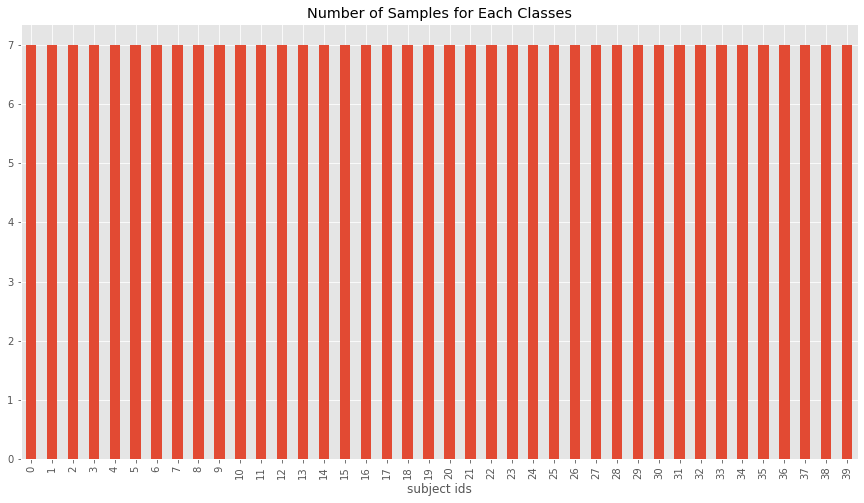

In [95]:
y_frame=pd.DataFrame()
y_frame['subject ids']=y_train
y_frame.groupby(['subject ids']).size().plot.bar(figsize=(15,8),title="Number of Samples for Each Classes")

<br>

### 4.2. Principle Component Analysis

<p>
    The most common unsupervised transformation applications is to reduce data size. In the size reduction process, the dimension of the data reduced.
</p>
<p>
    Principle Component Analysis (PCA) is a method that allows data to be represented in a lesser size. According to this method, the data is transformed to new components and the size of the data is reduced by selecting the most important components.
</p>

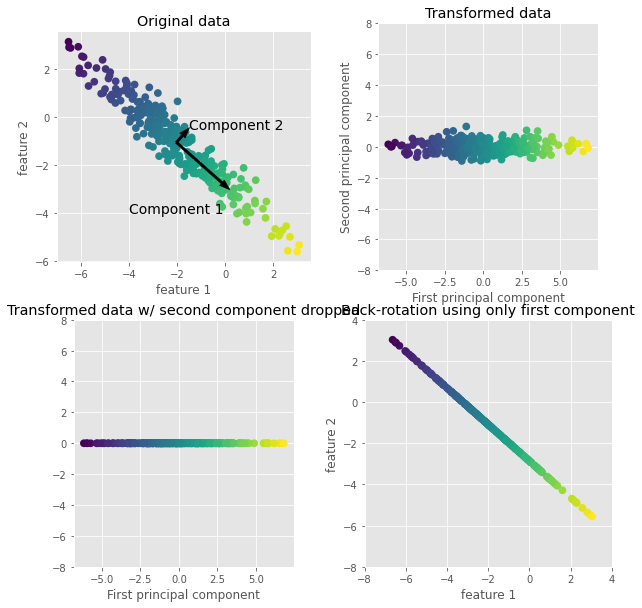

In [96]:
# scree plot
mglearn.plots.plot_pca_illustration()

The above illustration shows a simple example on a synthetic two-dimensional data set. The first drawing shows the original data points colored to distinguish points. The algorithm first proceeds by finding the direction of the maximum variance labeled ```Component 1```. This refers to the direction in which most of the data is associated, or in other words, the properties that are most related to each other.
<br>
Then, when the algorithm is orthogonal (at right angle), it finds the direction that contains the most information in the first direction. There are only one possible orientation in two dimensions at a right angle, but there will be many orthogonal directions (infinite) in high dimensional spaces.


<br>

### 4.3. PCA Projection of Defined Number of Target

In [97]:
pca=PCA(n_components=2)
print("=> ", pca)
pca.fit(X)
X_pca=pca.transform(X)
print("=> ", X_pca.shape)
print("=> ", X.shape)

=>  PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
=>  (400, 2)
=>  (400, 4096)


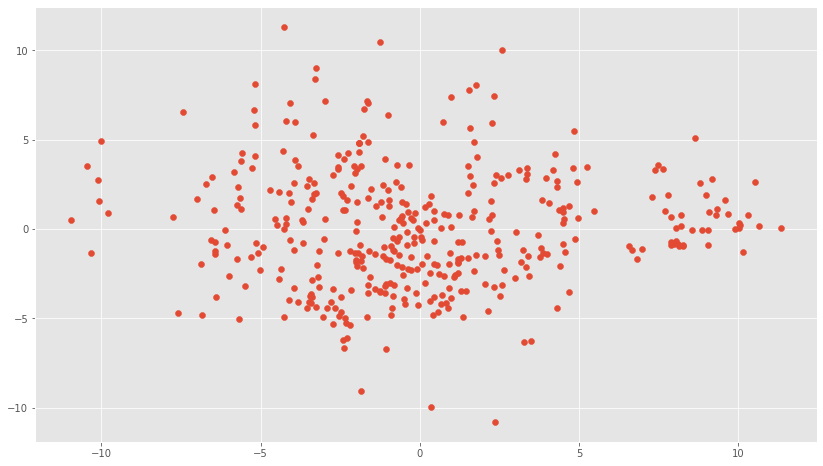

In [98]:
fig, axes = plt.subplots(figsize=(14 ,8))
plt.scatter(x=X_pca[0:, 0], y=X_pca[0:, 1])
plt.show()

In [99]:
# print(X_pca[0:, 1])

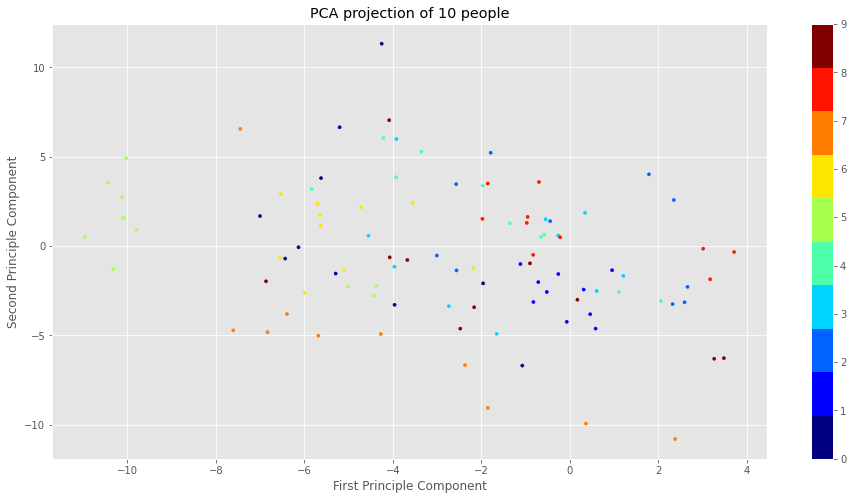

In [100]:
number_of_people=10
index_range=number_of_people*10
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(1,1,1)
scatter=ax.scatter(X_pca[:index_range,0],
            X_pca[:index_range,1], 
            c=target[:index_range],
            s=10,
            cmap=plt.get_cmap('jet', number_of_people))

ax.set_xlabel("First Principle Component")
ax.set_ylabel("Second Principle Component")
ax.set_title("PCA projection of {} people".format(number_of_people))

fig.colorbar(scatter)

<br>

### 4.4. Finding Optimum Number of Principle Component

This is important step because in this step we choose the number of principles components that is useful to fit the model.

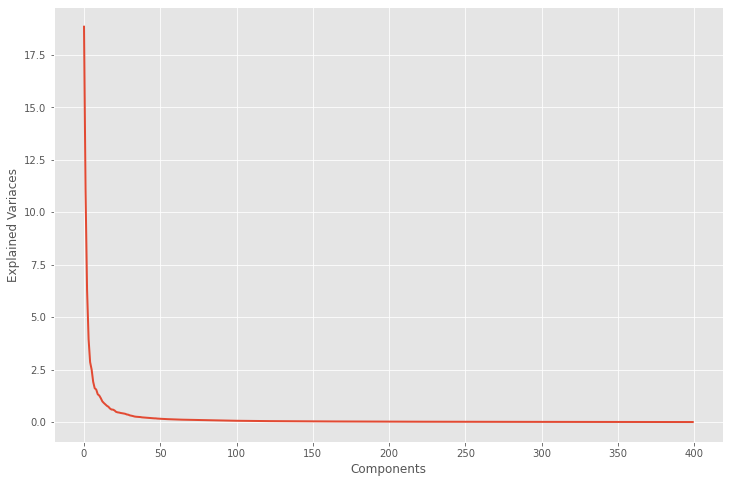

In [101]:
pca=PCA()
pca.fit(X)
plt.figure(1, figsize=(12,8))
# print(pca.explained_variance_)
plt.plot(pca.explained_variance_, linewidth=2)
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

In the figure above, it can be seen that 90 and more PCA components represent the same data. Now let's make the classification process using 90 PCA components.

In [147]:
n_components=90

In [148]:
pca=PCA(n_components=n_components, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=90, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

<br>

### 4.5. Show Average Face

Text(0.5, 1.0, 'Average Face')

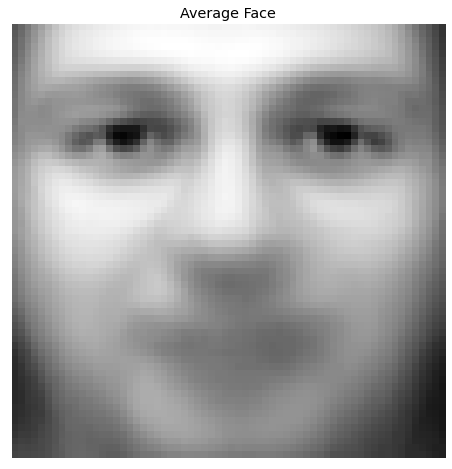

In [170]:
fig, ax=plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(pca.mean_.reshape((64,64)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

<br>

### 4.6. Show Eigen Faces

Text(0.5, 0.98, 'All Eigen Faces')

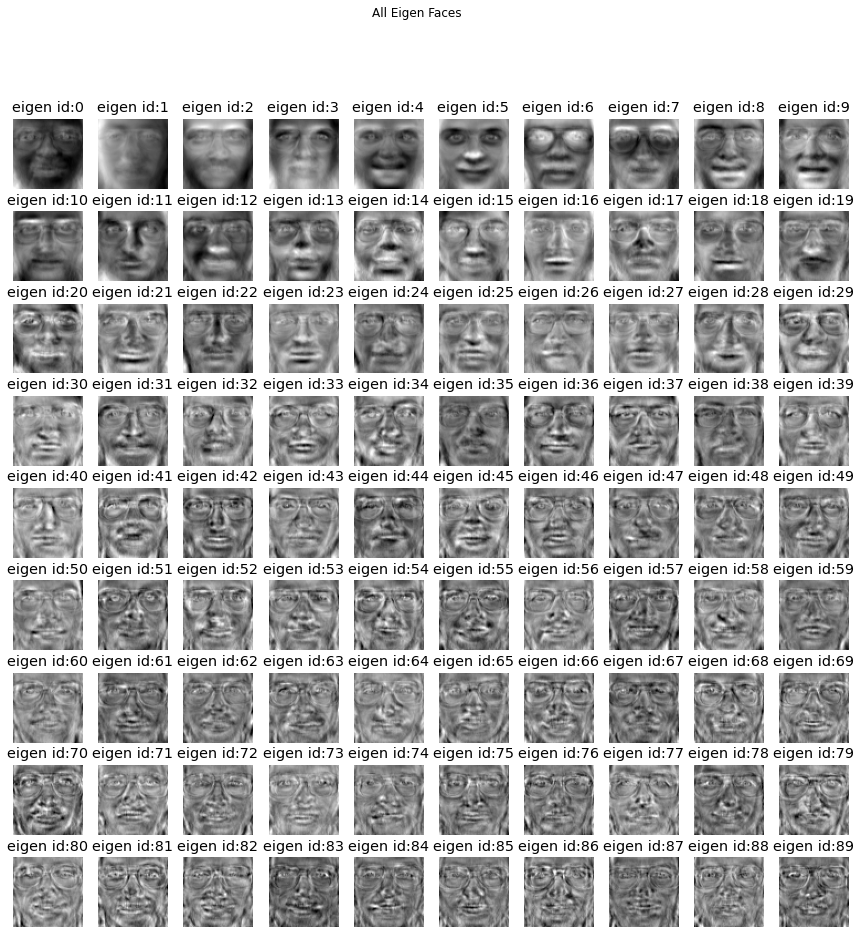

In [171]:
number_of_eigenfaces=len(pca.components_)
eigen_faces=pca.components_.reshape((number_of_eigenfaces, data.shape[1], data.shape[2]))

cols=10
rows=int(number_of_eigenfaces/cols)
fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
axarr=axarr.flatten()
for i in range(number_of_eigenfaces):
    axarr[i].imshow(eigen_faces[i],cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("eigen id:{}".format(i))
plt.suptitle("All Eigen Faces".format(10*"=", 10*"="))

<br>

### 4.7. Classification Results

In [172]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

In [173]:
clf = SVC()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("accuracy score:{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))

accuracy score:91.67%


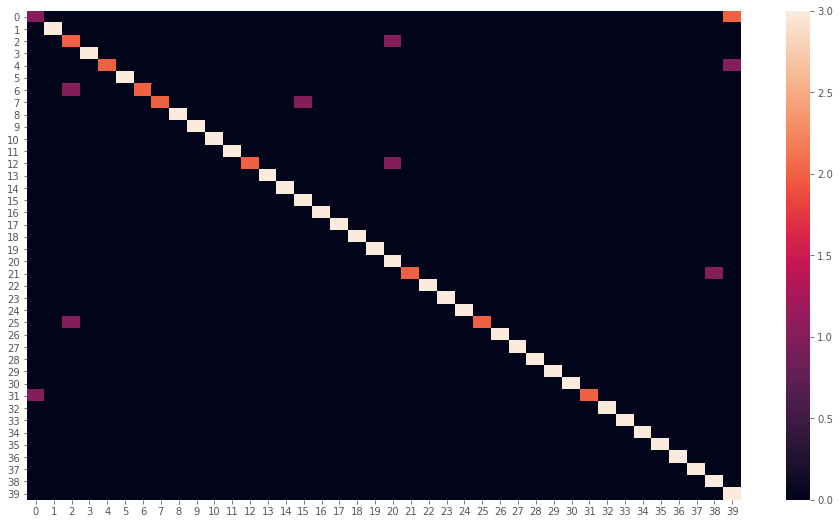

In [174]:
plt.figure(1, figsize=(16, 9))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred))

In [175]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       1.00      1.00      1.00         3
           2       0.50      0.67      0.57         3
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       0.75      1.00      0.86         3
          16       1.00      1.00      1.00         3
          17       1.00    

### Téléchargement de dataset

In [19]:
n_row, n_col = 2,2
n_components = n_row * n_col
image_shape = (64, 64)

In [20]:
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True)
n_samples, n_features = faces.shape
n_samples,n_features

(400, 4096)

### La fonction d'affichages des images

In [21]:
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        
        plt.imshow(comp.reshape(image_shape), cmap=cmap,interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

### L'affichages des 4 premiers visage

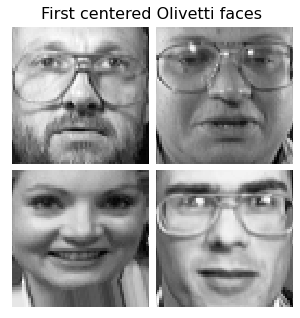

In [22]:
plot_gallery("First centered Olivetti faces", faces[:n_components])

### Le visage moyen

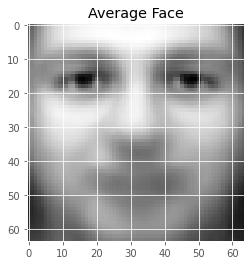

In [23]:
average_face = faces.mean(axis=0) # this is the average face

# SHowing the average face
plt.title(label="Average Face")
plt.imshow(average_face.reshape(64,64), cmap="gray")
plt.show()
#End of showing average face

faces_centered = faces - average_face

In [24]:
len(faces_centered)

400

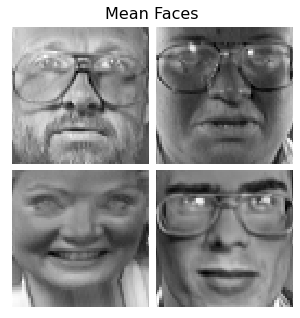

In [25]:
plot_gallery("Mean Faces", faces_centered[:n_components])

#### Réalisé par El Houcine ES SANHAJI

# Thank You